<a href="https://colab.research.google.com/github/RochanaChaturvedi/it-is-all-in-the-name/blob/add-license-1/Two_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Imports

In [ ]:
!pip install tensorflow==1.15
!pip install keras==2.4.1
!pip install -e git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain

In [9]:
import os
import pandas as pd
import re
import numpy as np
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import pickle 
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import seaborn as sns

from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split,StratifiedKFold, KFold
from keras import layers,initializers,regularizers,constraints
from keras.layers import Layer
import keras.initializers

from keras.models import Sequential
from keras.layers import Flatten,Multiply,Add,Permute,Dot,Activation,\
    AlphaDropout,RepeatVector, Dense, Bidirectional,LSTM, BatchNormalization, SpatialDropout1D,Dropout,\
    GlobalMaxPool1D,GlobalAveragePooling1D,Concatenate,Input,Conv1D, MaxPool1D, Embedding,TimeDistributed,Lambda, Reshape,TimeDistributed

from keras.utils import to_categorical
from keras.models import Model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.models import load_model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import keras.backend as K
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from itertools import compress
from sklearn.metrics import recall_score,log_loss
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import SGDClassifier

plt.style.use('ggplot')

# Global constants

In [10]:
eps=1e-20
np.random.seed(42)

base_dir= "/content/drive/My Drive/name_to_religion/"
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

data_dir= base_dir+"data/"
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

model_dir= base_dir+"model/"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

heatmap_dir= data_dir+"heatmap/"
if not os.path.isdir(heatmap_dir):
    os.mkdir(heatmap_dir)

# Load Training Data

In [11]:
#Clean data- call once
def clean_reds():
  data=pd.read_csv(data_dir+"REDS.csv")
  data.pname.replace(np.nan, '', regex=True,inplace=True)
  data.name=data.name.str.upper()
  data.pname=data.pname.str.upper()
  data.name.replace("\."," ", regex=True,inplace=True)
  data.pname.replace("\."," ", regex=True,inplace=True)
  data.name.replace("\s+"," ", regex=True,inplace=True)
  data.pname.replace("\s+"," ", regex=True,inplace=True)
  data=data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
  data.sex.fillna(3,inplace=True)
  data.to_csv(data_dir+"REDS_cleaned.csv",index=False)
  
clean_reds()

FileNotFoundError: ignored

In [17]:
def getTrain_data():
  data=pd.read_csv(data_dir+"REDS_cleaned.csv")    
  data.name.replace(" ","}{", regex=True,inplace=True)
  data.pname.replace(" ","}{", regex=True,inplace=True)
  data.name="{"+data.name.astype(str)+"}"
  data.pname="{"+data.pname.astype(str)+"}"
  if concat_model:
    if non_neural:
      data.name='#'+data.name.astype(str)+'#'+data.pname.astype(str)+'#' 
    else:  
      data.name='#'+data.name.astype(str)+'#'+data.pname.astype(str)+'#'
  x=data.name
  xp=data.pname
  xi=data.index
  y=data.muslim
  
  return(x,xi,y,xp)
# (_,_,_,_,_)=getTrain_data()

In [13]:
def getDataSplit():
  (x,_,y,xp)=getTrain_data()
  (x_train1, x_test,xp_train1,xp_test, y_train1, y_test) = train_test_split(x, xp,y, stratify=y, random_state=42,test_size=0.1)
  (x_train, x_val,xp_train,xp_val, y_train, y_val)= train_test_split(x_train1, xp_train1, y_train1,random_state=42, stratify=y_train1, test_size=0.1111)
  return (x_train,x_val,x_test,xp_train,xp_val,xp_test,y_train,y_val,y_test)

In [14]:
def load_upsbm():
  data_test_sbm = pd.read_csv(data_dir+"upsbm_annotated.csv")

  data_test_sbm.familyhead=data_test_sbm.familyhead.str.upper()
  data_test_sbm.fatherhusbandname=data_test_sbm.fatherhusbandname.str.upper()

  data_test_sbm.familyhead.replace("\."," ", regex=True,inplace=True)
  data_test_sbm.familyhead.replace("([A-Z])\\1\\1+","\\1", regex=True,inplace=True)
  data_test_sbm.familyhead.replace("\s+"," ", regex=True,inplace=True)

  data_test_sbm.fatherhusbandname.replace("\."," ", regex=True,inplace=True)
  data_test_sbm.fatherhusbandname.replace("([A-Z])\\1\\1+","\\1", regex=True,inplace=True)
  data_test_sbm.fatherhusbandname.replace("\s+"," ", regex=True,inplace=True)

  data_test_sbm = data_test_sbm.apply(lambda x: x.str.strip(" ") if x.dtype == "object" else x)
  
  data_test_sbm.familyhead.replace(" ","}{", regex=True,inplace=True)
  data_test_sbm.fatherhusbandname.replace(" ","}{", regex=True,inplace=True)

  y_sbm = data_test_sbm.muslim.map(lambda y:"Muslim" if y==1 else "Others")
  x_sbm="{"+data_test_sbm.familyhead.astype(str)+"}"
  xp_sbm="{"+data_test_sbm.fatherhusbandname.astype(str)+"}"
  if(concat_model):
    if non_neural:
      x_sbm="#"+x_sbm+"#"+xp_sbm+"#"  
    else:
      x_sbm="#"+x_sbm+"#"+xp_sbm+"#"
  
  return x_sbm,xp_sbm,y_sbm

# x_sbm,xp_sbm,y_sbm=load_upsbm()

# Models

## non_neural: SVM Linear/logistic

In [15]:
non_neural=True
eps=1e-20
np.random.seed(42)

### train

In [ ]:
for classifier in ["LOGIT","SVM"]:
  for concat_model in[True,False]:
    if classifier=="LOGIT":
      if concat_model:
        C=7.5                #Hyperparameters obtained by tuning on validation set
        ngram=9
      else:
        C=6.95
        ngram=5
      clf = LogisticRegression(verbose=2, class_weight='balanced', random_state=42, n_jobs=-1, C=C)
    else:
      if concat_model:
        C=.32
        ngram=10
      else:
        C=.21
        ngram=9
      clf = svm.LinearSVC(verbose=2, class_weight='balanced', C=C)

    x_train,x_val,x_test,xp_train,xp_val,xp_test,y_train,y_val,y_test =getDataSplit() 
    if concat_model==False:
      d=pd.DataFrame({"name":x_train,"muslim":y_train})
      data2=pd.DataFrame({"name":xp_train,"muslim":y_train})
      data2=data2[data2.name!=""]
      data=pd.concat([d,data2],axis=0)
      x_train=d.name
      y_train=d.muslim
        
    vectorizer = TfidfVectorizer(min_df=5, max_df=.5, analyzer='char', ngram_range=(1, ngram))#max_features=40000
    vectorizer.fit(x_train)
    features=vectorizer.get_feature_names()
    tfidf_matrix_train = vectorizer.transform(x_train)
    tfidf_matrix_val = vectorizer.transform(x_val)
    tfidf_matrix_test = vectorizer.transform(x_test)
    clf.fit(tfidf_matrix_train, y_train)
    pickle.dump(clf,open(model_dir+'model_2class_'+classifier+'_concat_'+str(concat_model)+'.sav',"wb"))
    pickle.dump(vectorizer,open(model_dir+'vectorizer_2class_'+classifier+'_concat_'+str(concat_model)+'.sav',"wb"))

### Testing

LOGIT True
REDS validation Accuracy of classifier level 1: 0.99
              precision    recall  f1-score   support

         0.0     0.9980    0.9951    0.9966     10491
         1.0     0.9528    0.9800    0.9662      1051

    accuracy                         0.9938     11542
   macro avg     0.9754    0.9876    0.9814     11542
weighted avg     0.9939    0.9938    0.9938     11542



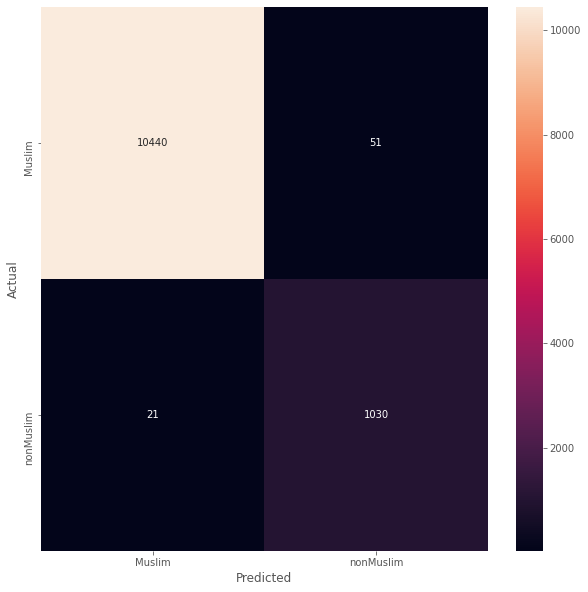

REDS test Accuracy of classifier level 1: 0.99
              precision    recall  f1-score   support

         0.0     0.9956    0.9946    0.9951     10492
         1.0     0.9463    0.9562    0.9513      1051

    accuracy                         0.9911     11543
   macro avg     0.9710    0.9754    0.9732     11543
weighted avg     0.9911    0.9911    0.9911     11543



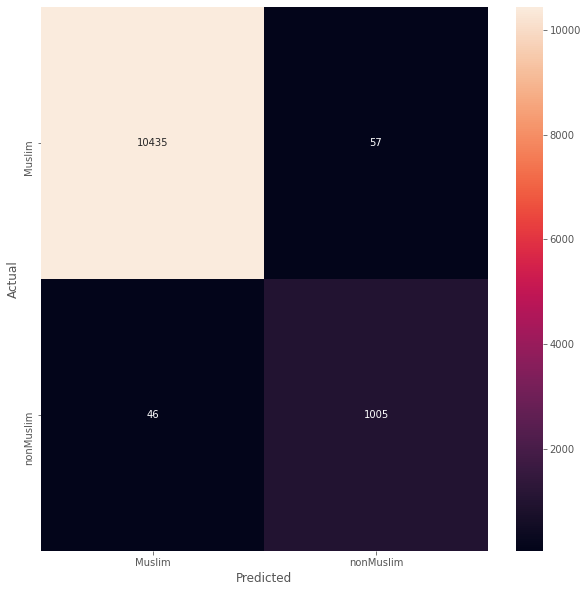

SBM Accuracy of classifier level 1: 0.98
              precision    recall  f1-score   support

       False     0.9891    0.9924    0.9908     17337
        True     0.9493    0.9290    0.9391      2663

    accuracy                         0.9839     20000
   macro avg     0.9692    0.9607    0.9649     20000
weighted avg     0.9838    0.9839    0.9839     20000



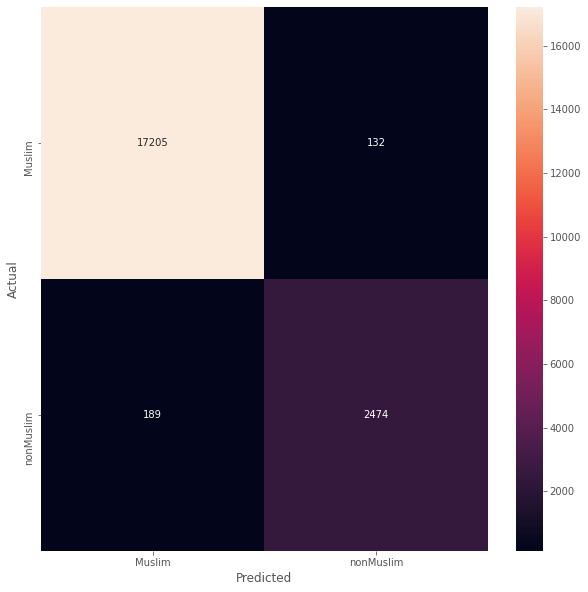

LOGIT False
REDS validation Accuracy of classifier level 1: 0.99
              precision    recall  f1-score   support

         0.0     0.9958    0.9899    0.9928     10491
         1.0     0.9048    0.9581    0.9307      1051

    accuracy                         0.9870     11542
   macro avg     0.9503    0.9740    0.9618     11542
weighted avg     0.9875    0.9870    0.9872     11542



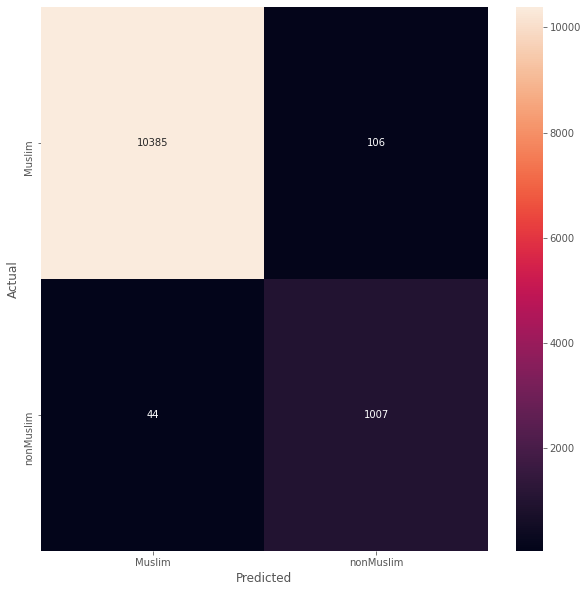

REDS test Accuracy of classifier level 1: 0.98
              precision    recall  f1-score   support

         0.0     0.9935    0.9888    0.9911     10492
         1.0     0.8928    0.9353    0.9136      1051

    accuracy                         0.9839     11543
   macro avg     0.9432    0.9620    0.9523     11543
weighted avg     0.9843    0.9839    0.9841     11543



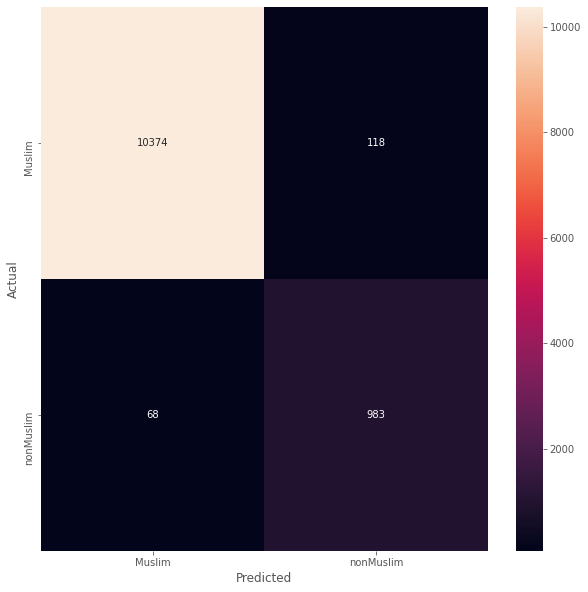

SBM Accuracy of classifier level 1: 0.95
              precision    recall  f1-score   support

       False     0.9798    0.9660    0.9728     17337
        True     0.7970    0.8701    0.8320      2663

    accuracy                         0.9532     20000
   macro avg     0.8884    0.9180    0.9024     20000
weighted avg     0.9554    0.9532    0.9541     20000



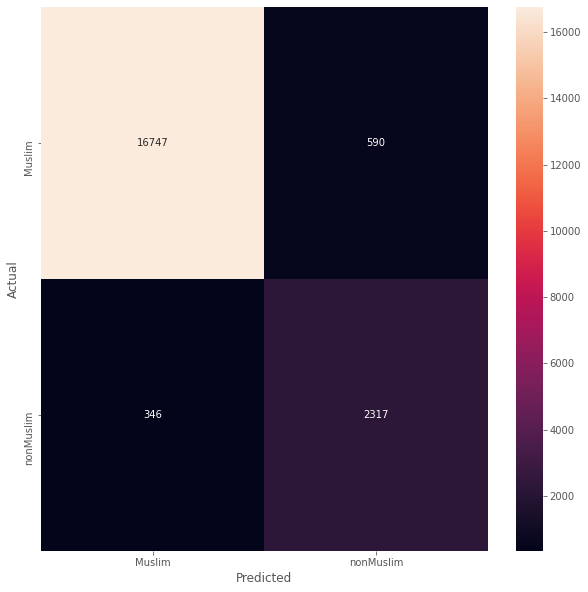

SVM True
REDS validation Accuracy of classifier level 1: 0.99
              precision    recall  f1-score   support

         0.0     0.9982    0.9953    0.9968     10491
         1.0     0.9547    0.9819    0.9681      1051

    accuracy                         0.9941     11542
   macro avg     0.9764    0.9886    0.9824     11542
weighted avg     0.9942    0.9941    0.9941     11542



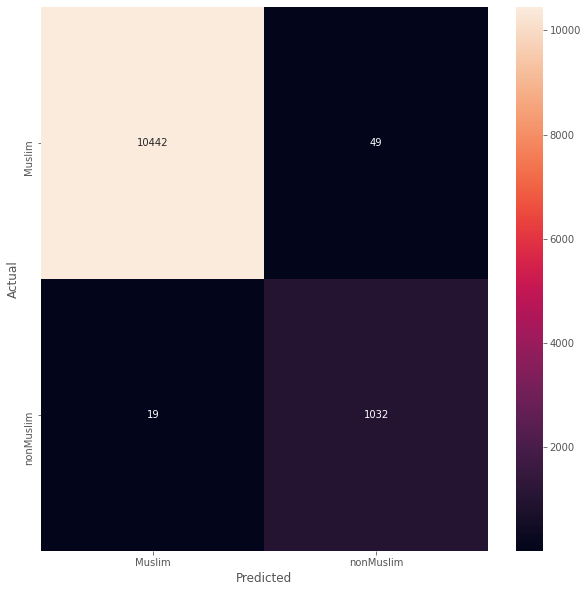

REDS test Accuracy of classifier level 1: 0.99
              precision    recall  f1-score   support

         0.0     0.9962    0.9936    0.9949     10492
         1.0     0.9378    0.9619    0.9497      1051

    accuracy                         0.9907     11543
   macro avg     0.9670    0.9778    0.9723     11543
weighted avg     0.9909    0.9907    0.9908     11543



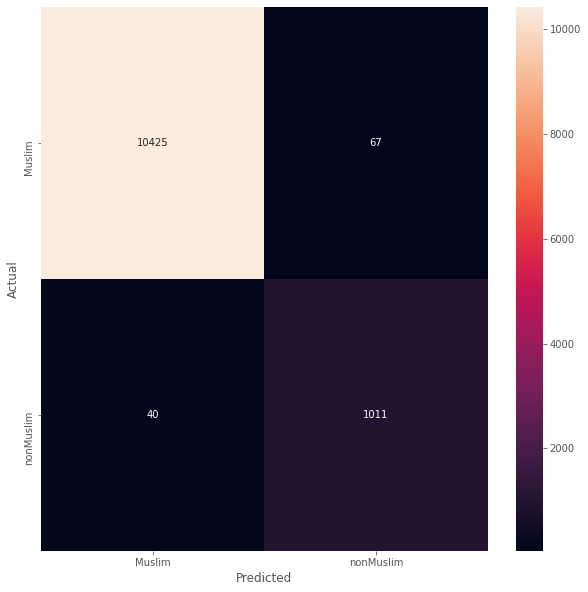

SBM Accuracy of classifier level 1: 0.98
              precision    recall  f1-score   support

       False     0.9903    0.9922    0.9912     17337
        True     0.9486    0.9365    0.9426      2663

    accuracy                         0.9848     20000
   macro avg     0.9695    0.9644    0.9669     20000
weighted avg     0.9847    0.9848    0.9848     20000



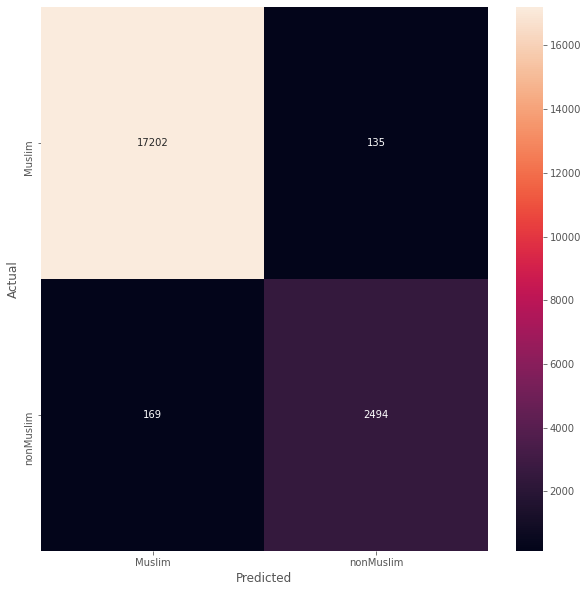

SVM False
REDS validation Accuracy of classifier level 1: 0.99
              precision    recall  f1-score   support

         0.0     0.9965    0.9918    0.9941     10491
         1.0     0.9218    0.9648    0.9428      1051

    accuracy                         0.9893     11542
   macro avg     0.9591    0.9783    0.9685     11542
weighted avg     0.9897    0.9893    0.9895     11542



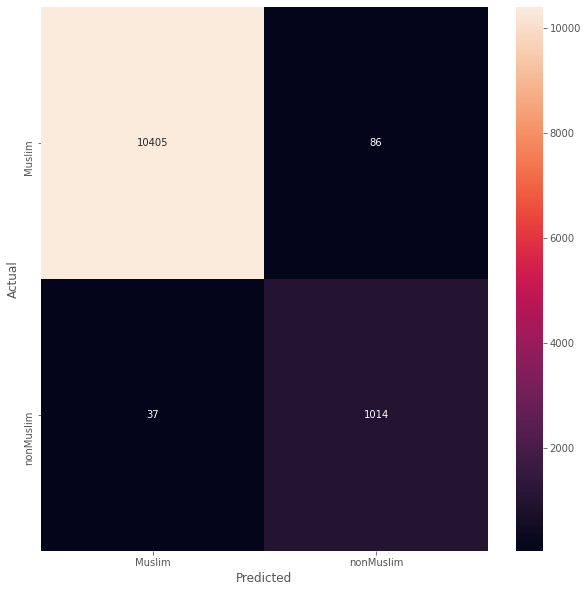

REDS test Accuracy of classifier level 1: 0.99
              precision    recall  f1-score   support

         0.0     0.9941    0.9897    0.9919     10492
         1.0     0.9015    0.9410    0.9209      1051

    accuracy                         0.9853     11543
   macro avg     0.9478    0.9654    0.9564     11543
weighted avg     0.9856    0.9853    0.9854     11543



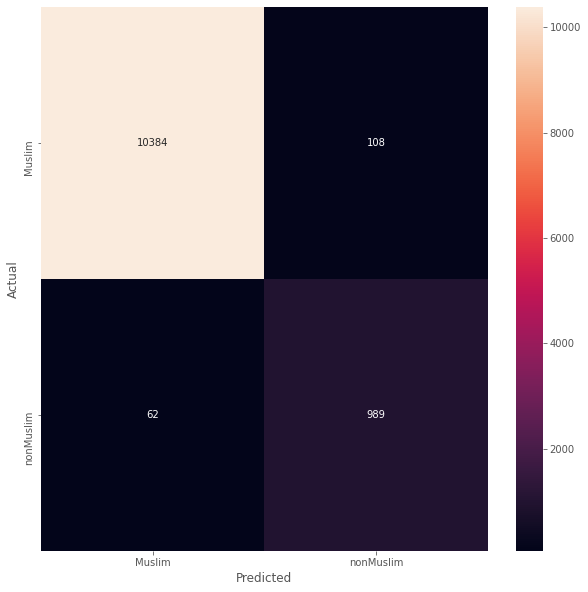

SBM Accuracy of classifier level 1: 0.96
              precision    recall  f1-score   support

       False     0.9813    0.9717    0.9765     17337
        True     0.8270    0.8795    0.8524      2663

    accuracy                         0.9595     20000
   macro avg     0.9041    0.9256    0.9145     20000
weighted avg     0.9608    0.9595    0.9600     20000



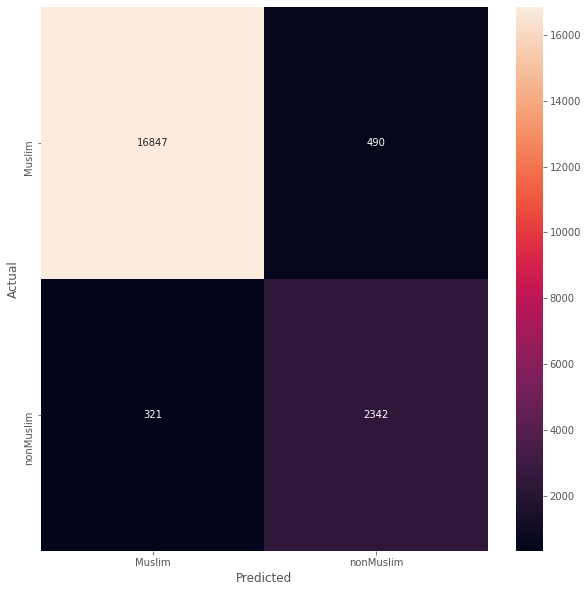

In [24]:
for classifier in ["LOGIT","SVM"]:
  for concat_model in [True,False]:
    print(classifier,concat_model)

    x_sbm,xp_sbm,y_sbm=load_upsbm()
    _,x_val,x_test,_,xp_val,xp_test,_,y_val,y_test =getDataSplit() 


    vectorizer = pickle.load(open(model_dir+'vectorizer_2class_'+classifier+'_concat_'+str(concat_model)+'.sav','rb'))
    clf=pickle.load(open(model_dir+'model_2class_'+classifier+'_concat_'+str(concat_model)+'.sav','rb'))
  
    tfidf_matrix_val = vectorizer.transform(x_val)
    tfidf_matrix_test = vectorizer.transform(x_test)
    tfidf_matrix_sbm= vectorizer.transform(x_sbm)

#reds val
    y_pred_val=clf.predict(tfidf_matrix_val)
    df=pd.DataFrame({"familyhead":x_val,"parent":xp_val,"religion":y_val,
                 "predicted":pd.Series(y_pred_val)})
    df.to_csv(data_dir+'val_predictions_2class_'+classifier+'_concat_'+str(concat_model)+'.csv')
    print('REDS validation Accuracy of classifier level 1: {:.2f}'.format(accuracy_score(y_val,y_pred_val)))
    print(classification_report(y_val,y_pred_val,digits=4))
    conf_mat = confusion_matrix(y_val,y_pred_val)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels={"nonMuslim","Muslim"}, yticklabels={"nonMuslim","Muslim"})
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

#reds_test
    y_pred_test=clf.predict(tfidf_matrix_test)
    df=pd.DataFrame({"familyhead":x_test,"parent":xp_test,"religion":y_test,
                 "predicted":pd.Series(y_pred_test)})
    df.to_csv(data_dir+'test_predictions_2class_'+classifier+'_concat_'+str(concat_model)+'.csv')

    print('REDS test Accuracy of classifier level 1: {:.2f}'.format(accuracy_score(y_test,y_pred_test)))
    print(classification_report(y_test,y_pred_test,digits=4))
    conf_mat = confusion_matrix(y_test,y_pred_test)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels={"nonMuslim","Muslim"}, yticklabels={"nonMuslim","Muslim"})
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

#UPSBM    
    y_pred_sbm=clf.predict(tfidf_matrix_sbm)
    df=pd.DataFrame({"familyhead":x_sbm,"parent":xp_sbm,"religion":y_sbm,
                 "predicted":pd.Series(y_pred_sbm)})

    df.to_csv(data_dir+'sbm_predictions_2class_'+classifier+'_concat_'+str(concat_model)+'.csv')

    print('SBM Accuracy of classifier level 1: {:.2f}'.format(accuracy_score(y_sbm=="Muslim",y_pred_sbm)))
    print(classification_report(y_sbm=="Muslim",y_pred_sbm,digits=4))
    conf_mat = confusion_matrix(y_sbm=="Muslim",y_pred_sbm)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels={"nonMuslim","Muslim"}, yticklabels={"nonMuslim","Muslim"})
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()  

### stage2

In [ ]:
# classifier ="LOGIT"
classifier="SVM"
concat_model= False
vectorizer = pickle.load(open(model_dir+'vectorizer_2class_'+classifier+'_concat_'+str(concat_model)+'.sav','rb'))
clf=pickle.load(open(model_dir+'model_2class_'+classifier+'_concat_'+str(concat_model)+'.sav','rb'))

In [ ]:
x_train,x_val,x_test,xp_train,xp_val,xp_test, y_train,y_val,y_test =getDataSplit() 
x_sbm,xp_sbm,y_sbm=load_upsbm()

tfidf_matrix_val = vectorizer.transform(x_val)
tfidf_matrix_test = vectorizer.transform(x_test)
tfidf_matrix_sbm= vectorizer.transform(x_sbm)
tfidf_matrix_train = vectorizer.transform(x_train)
tfidf_matrix_train_p=vectorizer.transform(xp_train)
tfidf_matrix_val_p=vectorizer.transform(xp_val)
tfidf_matrix_test_p=vectorizer.transform(xp_test)
tfidf_matrix_sbm_p= vectorizer.transform(xp_sbm)


if classifier=="LOGIT":
  y_pred_train=clf.predict_proba(tfidf_matrix_train)[:,1]
  y_pred_test=clf.predict_proba(tfidf_matrix_test)[:,1]
  y_pred_val=clf.predict_proba(tfidf_matrix_val)[:,1]
  y_pred_sbm=clf.predict_proba(tfidf_matrix_sbm)[:,1]
  y_pred_train=clf.predict_proba(tfidf_matrix_train)[:,1]
  pred_p_train=clf.predict_proba(tfidf_matrix_train_p)[:,1]
  pred_p_val=clf.predict_proba(tfidf_matrix_val_p)[:,1]
  pred_p_test=clf.predict_proba(tfidf_matrix_test_p)[:,1]
  pred_p_sbm=clf.predict_proba(tfidf_matrix_sbm_p)[:,1]
else:
  y_pred_train=clf.decision_function(tfidf_matrix_train)
  y_pred_test=clf.decision_function(tfidf_matrix_test)
  y_pred_val=clf.decision_function(tfidf_matrix_val)
  y_pred_sbm=clf.decision_function(tfidf_matrix_sbm)
  y_pred_train=clf.decision_function(tfidf_matrix_train)
  pred_p_train=clf.decision_function(tfidf_matrix_train_p)
  pred_p_val=clf.decision_function(tfidf_matrix_val_p)
  pred_p_test=clf.decision_function(tfidf_matrix_test_p)
  pred_p_sbm=clf.decision_function(tfidf_matrix_sbm_p)  

max_train=np.maximum(y_pred_train,pred_p_train)
log_x_train=np.log(np.clip(y_pred_train, eps, 1 - eps))
log_xp_train=np.log(np.clip(pred_p_train, eps, 1 - eps))
log_max_train=np.maximum(log_x_train,log_xp_train)
prod_train=np.multiply(y_pred_train,pred_p_train)
xlogp_train=np.multiply(y_pred_train,log_xp_train)
plogx_train=np.multiply(pred_p_train,log_x_train)

max_val=np.maximum(y_pred_val,pred_p_val)
log_x_val=np.log(np.clip(y_pred_val, eps, 1 - eps))
log_xp_val=np.log(np.clip(pred_p_val, eps, 1 - eps))
log_max_val=np.maximum(log_x_val,log_xp_val)
prod_val=np.multiply(y_pred_val,pred_p_val)
xlogp_val=np.multiply(y_pred_val,log_xp_val)
plogx_val=np.multiply(pred_p_val,log_x_val)

log_x_test=np.log(np.clip(y_pred_test, eps, 1 - eps))
log_xp_test=np.log(np.clip(pred_p_test, eps, 1 - eps))
log_max_test=np.maximum(log_x_test,log_xp_test)
max_test=np.maximum(y_pred_test,pred_p_test)
prod_test=np.multiply(y_pred_test,pred_p_test)
xlogp_test=np.multiply(y_pred_test,log_xp_test)
plogx_test=np.multiply(pred_p_test,log_x_test)

log_x_sbm=np.log(np.clip(y_pred_sbm, eps, 1 - eps))
log_xp_sbm=np.log(np.clip(pred_p_sbm, eps, 1 - eps))
log_max_sbm=np.maximum(log_x_sbm,log_xp_sbm)
max_sbm=np.maximum(y_pred_sbm,pred_p_sbm)
prod_sbm=np.multiply(y_pred_sbm,pred_p_sbm)
xlogp_sbm=np.multiply(y_pred_sbm,log_xp_sbm)
plogx_sbm=np.multiply(pred_p_sbm,log_x_sbm)


features_train=(y_pred_train,pred_p_train, max_train,log_x_train,log_xp_train,log_max_train,
                      prod_train, plogx_train,xlogp_train)
features_test=(y_pred_test,pred_p_test, max_test,log_x_test,log_xp_test,log_max_test,
                      prod_test, plogx_test,xlogp_test)
features_val=(y_pred_val,pred_p_val, max_val,log_x_val,log_xp_val,log_max_val,
                      prod_val, plogx_val,xlogp_val)
features_sbm=(y_pred_sbm,pred_p_sbm, max_sbm,log_x_sbm,log_xp_sbm,log_max_sbm,
                      prod_sbm, plogx_sbm, xlogp_sbm)

X_train=pd.DataFrame(np.column_stack(features_train))
X_val=pd.DataFrame(np.column_stack(features_val))
X_test=pd.DataFrame(np.column_stack(features_test))
X_sbm=pd.DataFrame(np.column_stack(features_sbm))

In [ ]:
opt = 2
score=0
classifier_1 =  svm.LinearSVC(verbose=0,class_weight='balanced', C=.4,max_iter=2000)

for i in range(2,10):   
  sel = RFE(classifier_1, i) 
  sel = sel.fit(X_train, y_train)
  X_train_=pd.DataFrame(np.column_stack(tuple(compress(features_train,sel.support_))))
  X_val_=pd.DataFrame(np.column_stack(tuple(compress(features_val,sel.support_))))

  classifier_1.fit(X_train_, list(y_train))
  pred_val=classifier_1.predict(X_val_)
  rec_score=recall_score(y_val, pred_val,average='macro')
  if rec_score>score:
    score=rec_score
    opt=i
    rfe=sel
  
rfe = RFE(classifier_1, opt)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
selected=rfe.support_

In [ ]:
X_train_=pd.DataFrame(np.column_stack(tuple(compress(features_train,selected))))
X_val=pd.DataFrame(np.column_stack(tuple(compress(features_val,selected))))
X_test=pd.DataFrame(np.column_stack(tuple(compress(features_test,selected))))
X_sbm=pd.DataFrame(np.column_stack(tuple(compress(features_sbm,selected))))

classifier_1.fit(X_train_, list(y_train))

In [ ]:
filename = model_dir+'2class_level2_'+classifier+'.sav'
pickle.dump((rfe,classifier_1), open(filename, 'wb'))

#### Testing

In [ ]:
pred2_val = classifier_1.predict(X_val)
print('Accuracy of LEVEL 2 on VAL set: {:.2f}'.format(accuracy_score(y_val, pred2_val)))
print(classification_report(y_val, pred2_val, digits=4))


pred2_test = classifier_1.predict(X_test)
print('Accuracy of LEVEL 2 on REDS test set: {:.2f}'.format(accuracy_score(y_test, pred2_test)))
print(classification_report(y_test, pred2_test, digits=4))


pred2_sbm = classifier_1.predict(X_sbm)
print('Accuracy of LEVEL 2 on SBM test set: {:.2f}'.format(accuracy_score(y_sbm=="Muslim", pred2_sbm)))
print(classification_report(y_sbm=="Muslim", pred2_sbm, digits=4))

## Neural Models

In [ ]:
def highway_layers(value, n_layers,initializer, activation="elu", gate_bias=-2):
    
    gate_bias_initializer = keras.initializers.Constant(gate_bias)
    for i in range(n_layers):     
        dim = K.int_shape(value)[-1]
        # print(dim)
        carry = Dense(units=dim, kernel_initializer=initializer,bias_initializer=gate_bias_initializer)(value)#carry gate
        carry = Activation(activation)(carry)
        negated_gate = Lambda(lambda x: 1.0 - x,output_shape=(dim,))(carry)
        transformed = Dense(units=dim,kernel_initializer=initializer)(value)
        transformed = Activation(activation)(transformed)
        transformed_gated = Multiply()([carry, transformed])#carry
        identity_gated = Multiply()([negated_gate, value])
        value = Concatenate()([transformed_gated, identity_gated])
    return value

### LSTM

In [ ]:
def final_LSTMmodel(shape, embedding_dim=20, drop_embed=0.1, dropout=.15, units=100, initializer='he_uniform', optimizer='Nadam'):
  x_can = Input(shape=(shape[0],), dtype='int32')
  embedding = Embedding(shape[1], embedding_dim, input_length=shape[0], trainable=True, embeddings_initializer=initializer)(x_can)
  embedding = Dropout(drop_embed)(embedding)
  embedding = SpatialDropout1D(drop_embed)(embedding) 
  x = CuDNNLSTM(units, kernel_initializer=initializer, return_sequences=True)(embedding)
  x = TimeDistributed(Dense(1))(x)
  x = GlobalMaxPool1D()(x)
  x= highway_layers(x,1,initializer)
  x = Dropout(dropout)(x)  
  x = Dense(1, activation="sigmoid",kernel_initializer=initializer)(x)
  model = Model(x_can,x)
  model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
  return model

### CNN

In [ ]:
def final_CNNmodel(shape, embedding_dim=20, activation='tanh', drop_embed=0.1, dropout=.25, 
                       kernel_sizes=[[1,150], [2,200], [3,250], [4, 300], [5,300], [6,300]], initializer='he_uniform',
                       optimizer='Nadam'):
  x_can = Input(shape=(shape[0],), dtype='int32')
  embedding = Embedding(shape[1], embedding_dim, input_length=shape[0], trainable=True, embeddings_initializer=initializer)(x_can)
  embedding = Dropout(drop_embed)(embedding)

  embedding = SpatialDropout1D(drop_embed)(embedding)
  convs = []
  
  for [kernel_size,num_filter] in kernel_sizes:
    l_conv = Conv1D(filters=num_filter, kernel_initializer=initializer, kernel_size=kernel_size,
                    padding='valid', name="Convolution"+str(kernel_size), activation=activation, strides=1)(embedding)
    l_pool= GlobalMaxPool1D()(l_conv)
    l_pool=AlphaDropout(.05)(l_pool)
    
    convs.append(l_pool)
  x = Concatenate(axis=1)(convs)
  x = Dropout(dropout)(x)  
  x = Dense(1, activation="sigmoid",kernel_initializer=initializer)(x)
  model = Model(x_can,x)
  model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
  return model

### CLSTM

In [ ]:
def final_CLSTMmodel(shape, embedding_dim=20, drop_embed=0.1, dropout=.25, units=250,
                       kernel_sizes=[[2,225],[3,275],[4,350],[5,350],[6,350]], initializer='he_uniform', optimizer='Nadam'):
  x_can = Input(shape=(shape[0],), dtype='int32')
  embedding = Embedding(shape[1], embedding_dim, input_length=shape[0], trainable=True, embeddings_initializer=initializer)(x_can)
  embedding = BatchNormalization()(embedding)
  embedding = SpatialDropout1D(drop_embed)(embedding)
  sentence_encoder = CuDNNLSTM(units, kernel_initializer=initializer,name="uni-LSTM", return_sequences=True)(embedding)
  sentence_encoder = TimeDistributed(Dense(1))(sentence_encoder)
  sentence_encoder = GlobalMaxPool1D()(sentence_encoder)
  sentence_encoder = Dropout(dropout)(sentence_encoder)
  convs = []
  convs.append(sentence_encoder)
  
  for [kernel_size,num_filter] in kernel_sizes:
    l_conv = Conv1D(filters=num_filter, kernel_initializer=initializer, kernel_size=kernel_size,
                    padding='valid', name="Convolution"+str(kernel_size), activation='tanh')(embedding)
    l_pool= MaxPool1D(kernel_size-1)(l_conv)
    l_pool=AlphaDropout(.05)(l_pool)
    sentence_encoder = CuDNNLSTM(units, kernel_initializer=initializer, return_sequences=True)(l_pool)
    sentence_encoder = TimeDistributed(Dense(1))(sentence_encoder)
    sentence_encoder = GlobalMaxPool1D()(sentence_encoder)
    sentence_encoder =Dropout(dropout)(sentence_encoder)
    convs.append(sentence_encoder)

  x = Concatenate(axis=1)(convs)
  x= highway_layers(x,1,initializer)
  x = Dropout(dropout)(x)  
  x = Dense(1, activation="sigmoid",kernel_initializer=initializer)(x)
  model = Model(x_can,x)
  model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
  return model

### Utility Functions

In [ ]:
def tokenize(x,max_char):
  unique_symbols = Counter()

  for _, name in x.iteritems():
      unique_symbols.update(name)

  num_unique_symbols = len(unique_symbols) #- len(uncommon_symbols) + 1 
  print("Unique symbols:",num_unique_symbols, unique_symbols)

  tokenizer = Tokenizer(
      char_level=True,
      filters=None,
      oov_token='#',
      lower=False,
      num_words=None
  )

  tokenizer.fit_on_texts([x])
  char_dict = {}
  ind_to_char={}
  for i, char in enumerate(unique_symbols):
    char_dict[char] = i + 1
    ind_to_char[i+1]=char
  tokenizer.word_index = char_dict.copy()
  print(char_dict)
  
  tokenizer.word_index[tokenizer.oov_token] = max(char_dict.values()) + 1
  ind_to_char[max(char_dict.values()) + 1]=tokenizer.oov_token
  max_char=max(map(len,x))
  x_sequences = tokenizer.texts_to_sequences(x)
  with open(data_dir+"tokenizer"+str(concat_model)+".pkl", "wb") as f:
      pickle.dump((tokenizer,max_char), f)
  
  return (num_unique_symbols+1,tokenizer)

In [ ]:
def getMaxchar():
  data=pd.read_csv(data_dir+"REDS_cleaned.csv")
  # data.name=data.name.str.upper()
  # data.name.replace("\."," ", regex=True,inplace=True)
  # data.name.replace("\s+"," ", regex=True,inplace=True)
  # data=data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
  data=pd.DataFrame({"index":data.index,"name":data.name,
                     "pname":data.pname,
                     "religion":data.religion,"muslim":data.muslim, "sex":data.sex})
  data.pname.replace(np.nan, '', regex=True,inplace=True)

  data.name.replace(" ","}{", regex=True,inplace=True)
  data.name="{"+data.name.astype(str)+"}"
  data.pname.replace(" ","}{", regex=True,inplace=True)
  data.pname="{"+data.pname.astype(str)+"}"  
  if(concat_model):    
    data.name='#'+data.name.astype(str)+"#"+data.pname.astype(str)+"#"
  max_char=max(map(len,data.name))
  vocab_size,tokenizer=tokenize(data.name,max_char)
  return max_char,tokenizer,vocab_size
max_char,tokenizer,vocab_size=getMaxchar()
print(max_char,vocab_size)

In [ ]:
def plot_hist(history):
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 3, 1)
  plt.plot(history['loss'], label='train_loss')
  plt.plot(history['val_loss'], label='test_loss')
  plt.title('Training and validation Loss')
  plt.legend()
  plt.subplot(1, 3, 2)
  plt.plot(history['acc'], label='train_Accuracy')
  plt.plot(history['val_acc'], label='test_Accuracy')
  plt.title('Training and validation Accuracy')
  plt.legend()
  plt.show()

In [ ]:
# Utility function for Level2
def map_logreg_features(X1,X2,support_):
  log_pred=np.log(np.clip(X1, eps, 1 - eps))
  log_pred_p=np.log(np.clip(X2, eps, 1 - eps))
  log_max=np.maximum(log_pred,log_pred_p)
  max_pred=np.maximum(X1,X2)
  prod_pred=np.multiply(X1,X2)
  ratio_pred=np.maximum(np.divide(X1,np.clip(X2, eps, 1 - eps)),
                              np.divide(X2,np.clip(X1, eps, 1 - eps)))
  plogx=np.multiply(X2,log_pred)
  xlogp=np.multiply(X1,log_pred_p)

  x=(X1,X2, max_pred,log_pred,log_pred_p,log_max,
                      prod_pred, ratio_pred,plogx,xlogp)

  x_col=['pred','pred_p', 'max_pred','log_pred','log_pred_p','log_max',
                      'prod_pred', 'ratio_pred','plogx','xlogp']
                      
  res=pd.DataFrame(np.column_stack(tuple(compress(x,support_))),
                   columns = list(compress(x_col,support_)))
  return res

### Train

#### Level 0 Neural

In [ ]:
def trainCLSTMModel(model_fn,model_name,initial_epoch=0,epoch=25,model=None):
  x_train,x_val,_,xp_train,xp_val,_,_,_,_,y_train,y_val,_=getDataSplit()
  
  if concat_model==False:
    df1=pd.DataFrame({"x":x_train,"y":y_train})
    df2=pd.DataFrame({"x":xp_train,"y":y_train})
    df2 = df2[df2.x!=""]
    df=pd.concat([df1,df2],axis=0)

    dfv1=pd.DataFrame({"x":x_val,"y":y_val})
    dfv2=pd.DataFrame({"x":xp_val,"y":y_val})
    dfv2 = dfv2[dfv2.x!=""]
    dfv=pd.concat([dfv1,dfv2],axis=0)
    x_train=df.x
    x_val=dfv.x
    y_train=df.y
    y_val=dfv.y
    
  padded_sequences_x=tokenizer.texts_to_sequences(x_train)
  xtrain=pad_sequences(padded_sequences_x, maxlen=max_char,padding='post', truncating='post')
  
  padded_sequences_x=tokenizer.texts_to_sequences(x_val)
  xval=pad_sequences(padded_sequences_x, maxlen=max_char,padding='post', truncating='post')

  class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=5, min_lr=0.0003)
  
  mc = ModelCheckpoint(model_name,
                       monitor='val_loss', mode='min', save_best_only=True,verbose=1)
  shape=(xtrain.shape[1], vocab_size)
  if model==None:
    model=model_fn(shape,vocab_size)
  history=model.fit(xtrain, y_train,validation_data=(xval, y_val),initial_epoch =initial_epoch, epochs =epoch,
                      shuffle=True, batch_size = 512,verbose=1,callbacks=[mc,reduce_lr],class_weight=class_weights,
                      workers=-1, use_multiprocessing=True)
  
  model=load_model(model_name)
  return (model, history)

In [ ]:
# model_name='LSTM' if concat_model==False else 'LSTM_concat
# model_fn=final_LSTMmodel

# model_name='CNN' if concat_model==False else 'CNN_concat
# model_fn=final_CNNmodel

# model_name='CNNLSTM' if concat_model==False else 'CNNLSTM_concat'
# model_fn=final_CLSTMmodel

In [ ]:
%%time
model, history = trainCLSTMModel(model_fn,model_dir+'final_model_'+model_name+'.h5', 0, 20)
plot_hist(history.history)

#### Level 1 neural
<i> Run only if concat_model=False </i>

#### Load level 0

In [ ]:
model=load_model(model_dir+model_name+'.h5'})

#### Train ensemble/ Meta model

In [ ]:
(x_train,x_val,x_test,xp_train,xp_val,xp_test,y_train,y_val,y_test)=getDataSplit()

x_train=tokenizer.texts_to_sequences(x_train)
x_train=pad_sequences(x_train, maxlen=max_char,padding='post', truncating='post')

x_val=tokenizer.texts_to_sequences(x_val)
x_val=pad_sequences(x_val, maxlen=max_char,padding='post', truncating='post')

# %%time
pred_train=model.predict(x_train,batch_size=1024,verbose=1,use_multiprocessing=True,workers=-1)
pred_val=model.predict(x_val,batch_size=1024,verbose=1,use_multiprocessing=True,workers=-1)

xp_train=tokenizer.texts_to_sequences(xp_train)
xp_train=pad_sequences(xp_train, maxlen=max_char,padding='post', truncating='post')

xp_val=tokenizer.texts_to_sequences(xp_val)
xp_val=pad_sequences(xp_val, maxlen=max_char,padding='post', truncating='post')

# %%time
predp_train=model.predict(xp_train,batch_size=1024,verbose=1,use_multiprocessing=True,workers=-1)
predp_val=model.predict(xp_val,batch_size=1024,verbose=1,use_multiprocessing=True,workers=-1)


X_train=map_logreg_features(pred_train,predp_train,[True]*9)
X_val=map_logreg_features(pred_val,predp_val,[True]*9)

##### Feature Selection

In [ ]:
opt = 2
score=0
classifier_1 =  svm.LinearSVC(verbose=0, class_weight='balanced', C=.4, max_iter=2000, random_state=42)
for i in range(2,10):   
  sel = RFE(classifier_1, i) 
  sel = sel.fit(X_train, y_train)
  X_train_=map_logreg_features(pred_train,predp_train,sel.support_)
  X_val_=map_logreg_features(pred_val,predp_val,sel.support_)
  classifier_1.fit(X_train_, list(y_train))
  pred2_val=classifier_1.predict(X_val_)
  rec_score=recall_score(y_val, pred2_val,average='macro')
  if rec_score>score:
    score=rec_score
    opt=i
    rfe=sel
  
rfe = RFE(classifier_1, opt)
rfe = rfe.fit(X_train, y_train)
selected=rfe.support_

In [ ]:
X_train_=map_logreg_features(pred_train,predp_train,rfe.support_)
X_val_=map_logreg_features(pred_val,predp_val,rfe.support_)
classifier_1.fit(X_train_, list(y_train))
pred2_val = classifier_1.predict(X_val_)
print('Accuracy of LEVEL 2 on test set: {:.2f}'.format(accuracy_score(y_val, pred2_val)))
print(classification_report(y_val, pred2_val, digits=4))

##### Save meta learner

In [ ]:
# Save the trained model as a pickle string. 
filename = model_dir+'stage2_'+model_name+'.sav'
pickle.dump(classifier_1, open(filename, 'wb'))
filename = model_dir+'rfe_'+model_name+'.sav'
pickle.dump(rfe, open(filename, 'wb'))  

### Test

#### Load models, other objects

In [ ]:
concat_model=False
# model_name='LSTM' if concat_model==False else 'LSTM_concat'
model_name='CNN' if concat_model==False else 'CNN_concat'
# model_name='CNNLSTM' if concat_model==False else 'CNNLSTM_concat'
model_path=model_dir+model_name+'.h5'
model = load_model(model_path,custom_objects={"f1":f1})
if concat_model==False:
  logreg = pickle.load(open(model_dir+'stage2_'+model_name+'.sav','rb'))
  rfe = pickle.load(open(model_dir+'rfe_'+model_name+'.sav','rb'))
with open(data_dir+"tokenizer"+str(concat_model)+".pkl", "rb") as f:
    (tokenizer,max_char)=pickle.load(f)

#### REDS TEST SET

In [ ]:
_,_,x_test,_,_,xp_test,_,_,y_test = getDataSplit() 

##### Level 0

In [ ]:
x_test=tokenizer.texts_to_sequences(x_test)
xtest=pad_sequences(x_test, maxlen=max_char,padding='post', truncating='post')

y_pred=model.predict(xtest,batch_size=1024,verbose=1,use_multiprocessing=True,workers=-1)
results = confusion_matrix(y_test, np.round(y_pred)) 
print('Confusion Matrix general:')
print(results) 
print('Accuracy Score general:',accuracy_score(y_test, np.round(y_pred)))
print('Report general: ')
print(classification_report(y_test, np.round(y_pred),digits=4,target_names=['non-muslim','muslim']))

##### Level 1

In [ ]:
xp_test=tokenizer.texts_to_sequences(xp_test)
xp_test=pad_sequences(xp_test, maxlen=max_char,padding='post', truncating='post')
pred_p=model.predict(xp_test,batch_size=1024,verbose=1,use_multiprocessing=True,workers=-1)

X= map_logreg_features(y_pred,pred_p,rfe.support_)

predictions = logreg.predict(X)
print("general predictions:")
results = confusion_matrix(y_test, np.round(predictions)) 
print(results) 
print('REDS TEST Accuracy Score Stage2:',accuracy_score(y_test, np.round(predictions)))
print('Report general: ')
print(classification_report(y_test, np.round(predictions), digits=4,target_names=['non-muslim','muslim']))

#### TEST SBM 

In [ ]:
x_sbm,xp_sbm,y_sbm=load_upsbm()

padded_sequences_xsbm=tokenizer.texts_to_sequences(x_sbm)
xsbm=pad_sequences(padded_sequences_xsbm, maxlen=max_char,padding='post', truncating='post')
y_pred_sbm=model.predict(xsbm,batch_size=1024,verbose=1,use_multiprocessing=True,workers=-1)

if concat_model==False:
  padded_sequences_xpsbm=tokenizer.texts_to_sequences(xp_sbm)
  xpsbm=pad_sequences(padded_sequences_xpsbm, maxlen=max_char,padding='post', truncating='post')
  y_pred_sbm_p=model.predict(xpsbm,batch_size=1024,verbose=1,use_multiprocessing=True,workers=-1)


##### Level 0

In [ ]:
results = confusion_matrix(y_sbm=="Muslim", np.round(y_pred_sbm)) 
print('Confusion Matrix general:')
print(results) 
print('Accuracy Score general:',accuracy_score(y_sbm=="Muslim", np.round(y_pred_sbm)))
print('Report general: ')
print(classification_report(y_sbm=="Muslim", np.round(y_pred_sbm),digits=4,target_names=['non-muslim','muslim']))

##### Level 1

In [ ]:
X_sbm= map_logreg_features(y_pred_sbm,y_pred_sbm_p,rfe.support_)
predictions = logreg.predict(X_sbm)

print("general predictions:")
results = confusion_matrix(y_sbm=="Muslim", np.round(predictions)) 
# print('Confusion Matrix general:')
print(results) 
print('Accuracy Score general:',accuracy_score(y_sbm=="Muslim", np.round(predictions)))
print('Report general: ')
print(classification_report(y_sbm=="Muslim", np.round(predictions), digits=4,target_names=['non-muslim','muslim']))

# Explaining CNN Predictions using LRP

In [ ]:
x_train,x_val,x_test,xp_train,xp_val,xp_test,xs_train,xs_val,xs_test,y_train,y_val,y_test = getDataSplit() 

In [ ]:
from deepexplain.tensorflow import DeepExplain
with open(data_dir+"tokenizer.pkl", "rb") as f:
    (tokenizer,max_char)=pickle.load(f)
padded_sequences_test=tokenizer.texts_to_sequences(x_test)
xtest=pad_sequences(padded_sequences_test, maxlen=max_char,padding='post', truncating='post')
model=load_model(model_dir+'CNN.h5')
pred=model.predict(xtest)

In [ ]:
from matplotlib import cm, transforms,colors
def plot_text_heatmap(chars, scores, filename, title="", width=10, height=0.2, verbose=0, max_word_per_line=46):
    plt.clf() 
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = chars
    # if verbose > 0:
    #     print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2
    threshold=normalized_scores.max()/4
    textcolors= ["black", "white"]
    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token, color= textcolors[int(normalized_scores[i] < threshold)],
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')
    
    plt.savefig(heatmap_dir+filename+".png",dpi=90,format='png',bbox_inches='tight')#pad_inches=.5)
    plt.close()

In [ ]:
df=pd.DataFrame({"y_true":y_test,"xname":x_test,"y_pred":pred.flatten(),"sex":xs_test})
df_correct_NM = df[(df.y_pred<0.5) & (df.y_true==0.0)]
df_correct_M = df[(df.y_pred>=0.5) & (df.y_true==1.0)]

In [ ]:
df_nm_female=df_correct_NM[df_correct_NM.sex]
df_nm_female=df_nm_female.nsmallest(5, 'y_pred')

In [ ]:
df_m_female=df_correct_M[df_correct_M.sex]
dfplpl=dfplpl.nlargest(5, 'y_pred')
dfplpl

In [ ]:
df_NM=df_correct_NM.nsmallest(20, 'y_pred')
df_M=df_correct_M.nlargest(50, 'y_pred')

In [ ]:
names=df_M.xname
padded_sequences=tokenizer.texts_to_sequences(names)
x=pad_sequences(padded_sequences, maxlen=max_char,padding='post', truncating='post')

In [ ]:
def explain(x):
  with DeepExplain(session=K.get_session()) as de:
          model=load_model(model_dir+'CNN.h5'})
          dense = Dense(1,kernel_initializer="he_uniform")(model.layers[-2].output)
          fmodel=Model(model.input,dense)
          fmodel.set_weights(model.get_weights())
          fmodel.compile(optimizer='nadam', loss='binary_crossentropy',metrics=['accuracy',f1])
          input_tensor = fmodel.get_layer("input_13").input #layers[0].input
          embedding = fmodel.get_layer("embedding_13").output #layers[1].output
          get_embedding_out = K.function([input_tensor],[embedding])
          embedding_out=get_embedding_out([x])[0]
          pre_softmax_tensor = fmodel.layers[-1].output
          attributions = de.explain('elrp',  pre_softmax_tensor, embedding, embedding_out)
          attr= np.sum(attributions, -1)
    return attr

In [ ]:
#For global attributions on test set
df=pd.DataFrame({"name":x_test,"y":y_test,"pred":pred.flatten(),"sex":xs_test})
attr= explain(x_test)
attrdf=pd.DataFrame(attr)
df.reset_index(drop=True, inplace=True)
attrdf.reset_index(drop=True, inplace=True)
df2=pd.concat([df,attrdf],axis=1,sort=False)
df2.to_csv("/content/drive/My Drive/name_to_religion/data/attributions.csv",index=False)

# Plot of decision boundary

In [ ]:
# define function to map higher order polynomial features
def mapFeature(X1,X2,support=None, degree=None,poly=False,gender=None): 
    if poly==True:
      res = np.ones(X1.shape[0])
      
      for i in range(1,degree + 1):
            for j in range(0,i + 1):
                res = np.column_stack((res, (X1 ** (i-j)) * (X2 ** j)))
    else:
      if gender==1:
        g=np.ones((len(X1)))# assumer all non female
      else:
        g=np.zeros((len(X1)))
      res=map_logreg_features(X1,X2,support)
    return res

def sigmoid(z):
  return 1 / (1 + np.exp(-z))
def costFunc(theta, X, y):
  m = y.shape[0]
  z = X.dot(theta)
  h = sigmoid(z)
  term1 = y * np.log(h)
  term2 = (1- y) * np.log(1 - h)
  J = -np.sum(term1 + term2, axis = 0) / m
  return J 

def plotDecisionBoundary(axes,degree=None,support=None,poly=False,gender=0,mod=None): 
  u = np.linspace(0, 1, 2000)
  v = np.linspace(0, 1, 2000)
  U,V = np.meshgrid(u,v)
  # convert U, V to vectors for calculating additional features
  # using vectorized implementation
  U = np.ravel(U)
  V = np.ravel(V)
  Z = np.zeros((len(u) * len(v)))
  
  X_poly = mapFeature(U, V,support, degree,poly,gender)
  #   # Z = X_poly.dot(mod)
  Z = mod.predict(X_poly)
  
  # reshape U, V, Z back to matrix
  U = U.reshape((len(u), len(v)))
  V = V.reshape((len(u), len(v)))
  Z = Z.reshape((len(u), len(v)))
  
  cs = axes.contour(U,V,Z,levels=[0], linewidths=2,cmap= "Greys_r")

  # axes.legend(labels=['Muslim', 'Non-Muslim', 'Decision Boundary'])
  return cs

def plot_boundary(df,poly,gender=0):
  pos = df['muslim'] == 1
  neg = df['muslim'] == 0
  if poly==True:
    degree = 10

# Get the features 
  X = df.iloc[:, :2]
  if poly==True:
    X_poly = mapFeature(X.iloc[:, 0], X.iloc[:, 1],None, degree,poly)
  else:
    X_poly= mapFeature(X.iloc[:, 0], X.iloc[:, 1], rfe.support_,None,poly,gender)
  # Get the target variable
  y = df.iloc[:, 2]

  fig, axes = plt.subplots(figsize=(8, 8));
  axes.set_frame_on(False)
  
  # axes.axvline()
  # axes.axes.axhline()

  axes.set_xlabel('Probability Individual')
  axes.set_ylabel('Probability Parent/Spouse')
  
  axes.scatter(df.loc[pos, 'pred'], df.loc[pos, 'pred_p'], color = 'red', marker='+', label='Muslim',alpha=.8)
  axes.scatter(df.loc[neg, 'pred'], df.loc[neg, 'pred_p'], color = 'blue', marker='.', label='Non-Muslim',alpha=0.7)
  axes.grid(color=(.99,.99,.99), linestyle='-', linewidth=0.25, alpha=0.5)
  
  axes.legend(bbox_to_anchor=(.62,-.1),framealpha=1,edgecolor='black',facecolor='white')
  axes.set_xlim(0,1)
  axes.set_ylim(0,1)
  font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
  plt.rc('font', **font)
  if poly==True:
    mod=LogisticRegression(verbose=1,class_weight='balanced')
  else: 
    plotDecisionBoundary(axes,None,rfe.support_, poly,gender,logreg)

  axes.set_rasterized(True)
  plt.savefig("/content/drive/My Drive/name_to_religion/decision_boundary.eps",dpi=250,format='eps',bbox_inches='tight')#pad_inches=.5)

In [ ]:
_,_,x_test,_,_,xp_test,_,_,y_test = getDataSplit() 
x_test=tokenizer.texts_to_sequences(x_test)
xtest=pad_sequences(x_test, maxlen=max_char,padding='post', truncating='post')
pred=mod_append.predict(xtest, batch_size=1024,verbose=1, use_multiprocessing=True, workers=-1)

xp_test=tokenizer.texts_to_sequences(xp_test)
xptest=pad_sequences(xp_test, maxlen=max_char,padding='post', truncating='post')
pred_p=mod_append.predict(xptest, batch_size=1024,verbose=1, use_multiprocessing=True, workers=-1)

dfm=pd.DataFrame({'pred':pred.flatten(),'pred_p':pred_p.flatten(), 'muslim':y_test})

plot_boundary(dfm,poly=False)

# Data_cleaning_old

In [ ]:
# data_parent_sbm=pd.read_stata("/content/drive/My Drive/name_to_religion/data/fatherhusbandname.dta")
# # data_parent_sbm.fatherhusbandname=data_parent_sbm.fatherhusbandname.str.upper()
# # data_parent_sbm.fatherhusbandname=data_parent_sbm.fatherhusbandname[~data_parent_sbm.fatherhusbandname.str.contains("[ÿÔÀô0ÞÐÎìéêØß,àÄÉ\\2`]",regex=True)]
# data_parent_sbm.fatherhusbandname.replace("[^A-Z .\-]","",regex=True,inplace=True)
# # data_parent_sbm.fatherhusbandname.replace("[?]+","", regex=True,inplace=True)
# data_parent_sbm.fatherhusbandname.replace("[.-]+"," ", regex=True,inplace=True)
# data_parent_sbm.fatherhusbandname.replace("\s+"," ", regex=True,inplace=True)
# data_parent_sbm=data_parent_sbm.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
# ## print(data_parent_sbm)
# ##print(sum(data_parent_sbm.fatherhusbandname.isnull()))
# ## print(data_parent_sbm.fatherhusbandname[data_parent_sbm.fatherhusbandname.str.contains("?",regex=False,na=False)])
# ## data_parent_sbm.fatherhusbandname.replace("[^A-Z ]+","", regex=True,inplace=True)

# data_test_sbm=pd.read_stata("/content/drive/My Drive/name_to_religion/data/familyhead.dta")
# data_test_sbm.familyhead.replace("[^A-Z .\-]","",regex=True,inplace=True)
# # data_parent_sbm.fatherhusbandname.replace("[?]+","", regex=True,inplace=True)
# data_test_sbm.familyhead.replace("[.-]+"," ", regex=True,inplace=True)
# data_test_sbm.familyhead.replace("\s+"," ", regex=True,inplace=True)
# data_test_sbm=data_test_sbm.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# # print(data_test_sbm.familyhead[data_test_sbm.familyhead.str.contains("[,]",regex=True)])
## data_test_sbm.familyhead=data_test_sbm.familyhead.str.upper()